- 下記の3blockは右のURLからコピーしてきた（後で使われるので）：https://github.com/youngsend/dlwpt-code/blob/master/p1ch6/1_neural_networks.ipynb
- 同じ温度計の例です。

In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
# add the extra dimension at axis 1 so that it can be processed by nn.Linear. 1 means in_features.
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  1,  9,  8,  7,  3, 10,  6,  2]), tensor([4, 0]))

In [6]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

t_un_val.shape

torch.Size([2, 1])

- A module can have one or more `Parameter` instances as attributes, which are tensors whose values are optimized during the training process.
- A module can also have one or more submodules as attributes, and it will be able to track their parameters as well.
    - The submodules must be top-level attributes, not buried inside `list` or `dict` instances!
    - Otherwise, the optimizer will not be able to locate the submodules (and, hence, their parameters).
    - **For situations where your model requires a list or dict of submodules, PyTorch provides `nn.ModuleList` and `nn.ModuleDict`**.

### 6.2.1 Using __call__ rather than forward
- All PyTorch-provided subclasses of `nn.Module` have their `__call__` method defined. つまりmodule自体はcallableだ。libtorchの場合はforwardを明示的に呼び出すしかない。

In [10]:
import torch.nn as nn
from PIL import Image

In [5]:
# in_features (size of each input sample), out_features (size of each output sample)
linear_model = nn.Linear(1, 1) 
linear_model(t_un_val)

tensor([[4.4180],
        [3.0130]], grad_fn=<AddmmBackward>)

- The `forward` method is what executes the forward computation, while **`__call__` does other rather important chores (雑用) before and after calling `forward`**.
    - So, it is technically possible to call `forward` directly, and it will produce the same output as `__call__`, but **this should not be done from user code**. libtorchでただforwardをcallしているけど。

### 6.2.2 Returning to the linear model
- If we used both temperature and barometric pressure as input, for instance, we would have two features in input and one feature in output.
    - in_featuresはsize of **each input sample**なので、`t_un_val`のshapeは`[2, 1]`、つまりeach sampleの長さは１です。なのでin_featuresは１。
    - Linearの例を見ると分かる：https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
- We have an instance of `nn.Linear` with one input and one output feature.
    - That only requires one weight and one bias:

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.6820]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.5781], requires_grad=True)

- To accommodate multiple samples, **modules expect the zeroth dimesion of the input to be the number of samples** in the batch.
- **Any module in `nn` is written to produce outputs for a batch of multiple inputs at the same time**.

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.2602],
        [1.2602],
        [1.2602],
        [1.2602],
        [1.2602],
        [1.2602],
        [1.2602],
        [1.2602],
        [1.2602],
        [1.2602]], grad_fn=<AddmmBackward>)

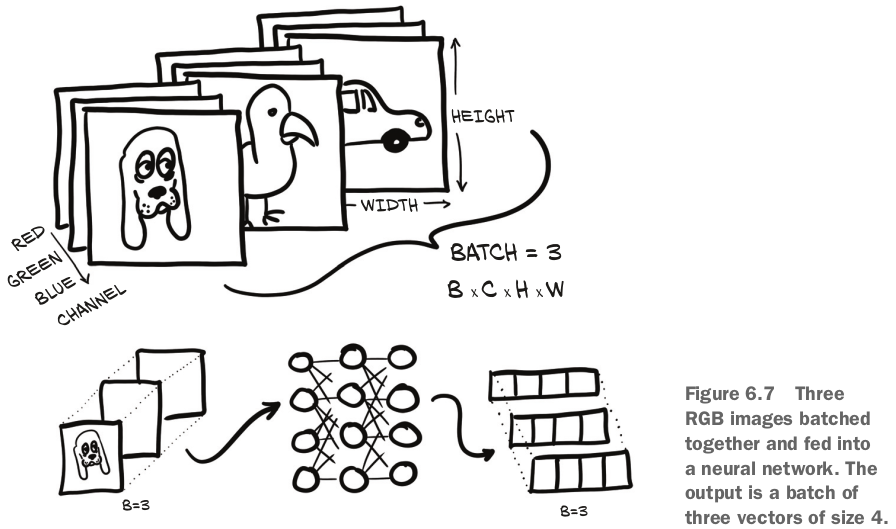

In [11]:
Image.open('img/batch-2020-12-26-13-45-02.png')

- batchを使うメリット：
    - By providing batches of inputs, the calculation can be spread across the otherwise-idle units, which means the **batched results come back just as quickly as a single result would**. 
    - Some advanced models use **statistical information from the entire batch**, and those statistics get better with larger batch sizes.
- Update training code: First, replace our handmade model with `nn.Linear(1, 1)`:

In [12]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

- Earlier, it was our responsibility to create parameters and pass them as the first argument to `optim.SGD`.
- Now we can use the `parameters` method to ask any `nn.Module` for a list of parameters owned by it or any of its submodules:

In [13]:
linear_model.parameters()

<generator object Module.parameters at 0x7fe8db3c6f10>

In [14]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.7459]], requires_grad=True),
 Parameter containing:
 tensor([-0.6154], requires_grad=True)]

- This call recurses (再帰呼び出しする) into submodules **defined in the module's `init` constructor** and returns a flat list of all parameters encountered.
- The training loop:

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train.item():.4f},'
                 f' Validation loss {loss_val.item():.4f}')

In [16]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs=3000,
             optimizer=optimizer,
             model=linear_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_un_val,
             t_c_train=t_c_train,
             t_c_val=t_c_val)

Epoch 1, Training loss 232.5534, Validation loss 68.6494
Epoch 1000, Training loss 3.5524, Validation loss 7.0841
Epoch 2000, Training loss 2.8413, Validation loss 4.6410
Epoch 3000, Training loss 2.8206, Validation loss 4.3079


In [19]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.2848]], requires_grad=True)
Parameter containing:
tensor([-16.4936], requires_grad=True)


## 6.3 Finally a neural network
### 6.3.1 Replacing the linear model

In [20]:
seq_model = nn.Sequential(nn.Linear(1, 13),
                         nn.Tanh(),
                         nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

### 6.3.2 Inspecting the parameters

In [21]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

- **These are the tensors that the optimizer will get**.
- Again, after we call `model.backward()`, all parameters are populated with their `grad`, and the optimizer then updates their values accordingly during the `optimizer.step()` call.
- もう１つparameterのnameもチェックできる方法：

In [22]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


- Interestingly, `Sequential` also accepts an `OrderedDict`, in which we can name each module passed to `Sequential` (libtorchで試したことない！):
- 僕の１つ疑問点解消された！：**Not all versions of Python specify the iteration order for `dict`, so we're using `OrderedDict` here to ensure the ordering of the layers and emphasize that the order of the layers matters**.

In [23]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [24]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


- We can also access a particular `Parameter` by using submodules as attributes:

In [25]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3064], requires_grad=True)

- This is useful for inspecting parameters or their gradients:

In [26]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000,
             optimizer=optimizer,
             model=seq_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_un_val,
             t_c_train=t_c_train,
             t_c_val=t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 246.6515, Validation loss 76.5160
Epoch 1000, Training loss 5.0943, Validation loss 3.7019
Epoch 2000, Training loss 4.4256, Validation loss 0.4463
Epoch 3000, Training loss 2.6449, Validation loss 1.0501
Epoch 4000, Training loss 2.0658, Validation loss 1.6054
Epoch 5000, Training loss 1.8868, Validation loss 1.9916
output tensor([[12.9496],
        [ 2.5021]], grad_fn=<AddmmBackward>)
answer tensor([[11.0000],
        [ 0.5000]])
hidden tensor([[ 7.3567e-01],
        [-1.3827e+01],
        [-6.2796e-01],
        [ 1.3836e+01],
        [ 1.3624e-02],
        [-1.2946e+01],
        [ 5.8370e-01],
        [-1.2550e+01]])


### 6.3.3 Comparing to the linear model
- We can also evaluate the model on all of the data and see how it differs from a line:

In [27]:
from matplotlib import pyplot as plt

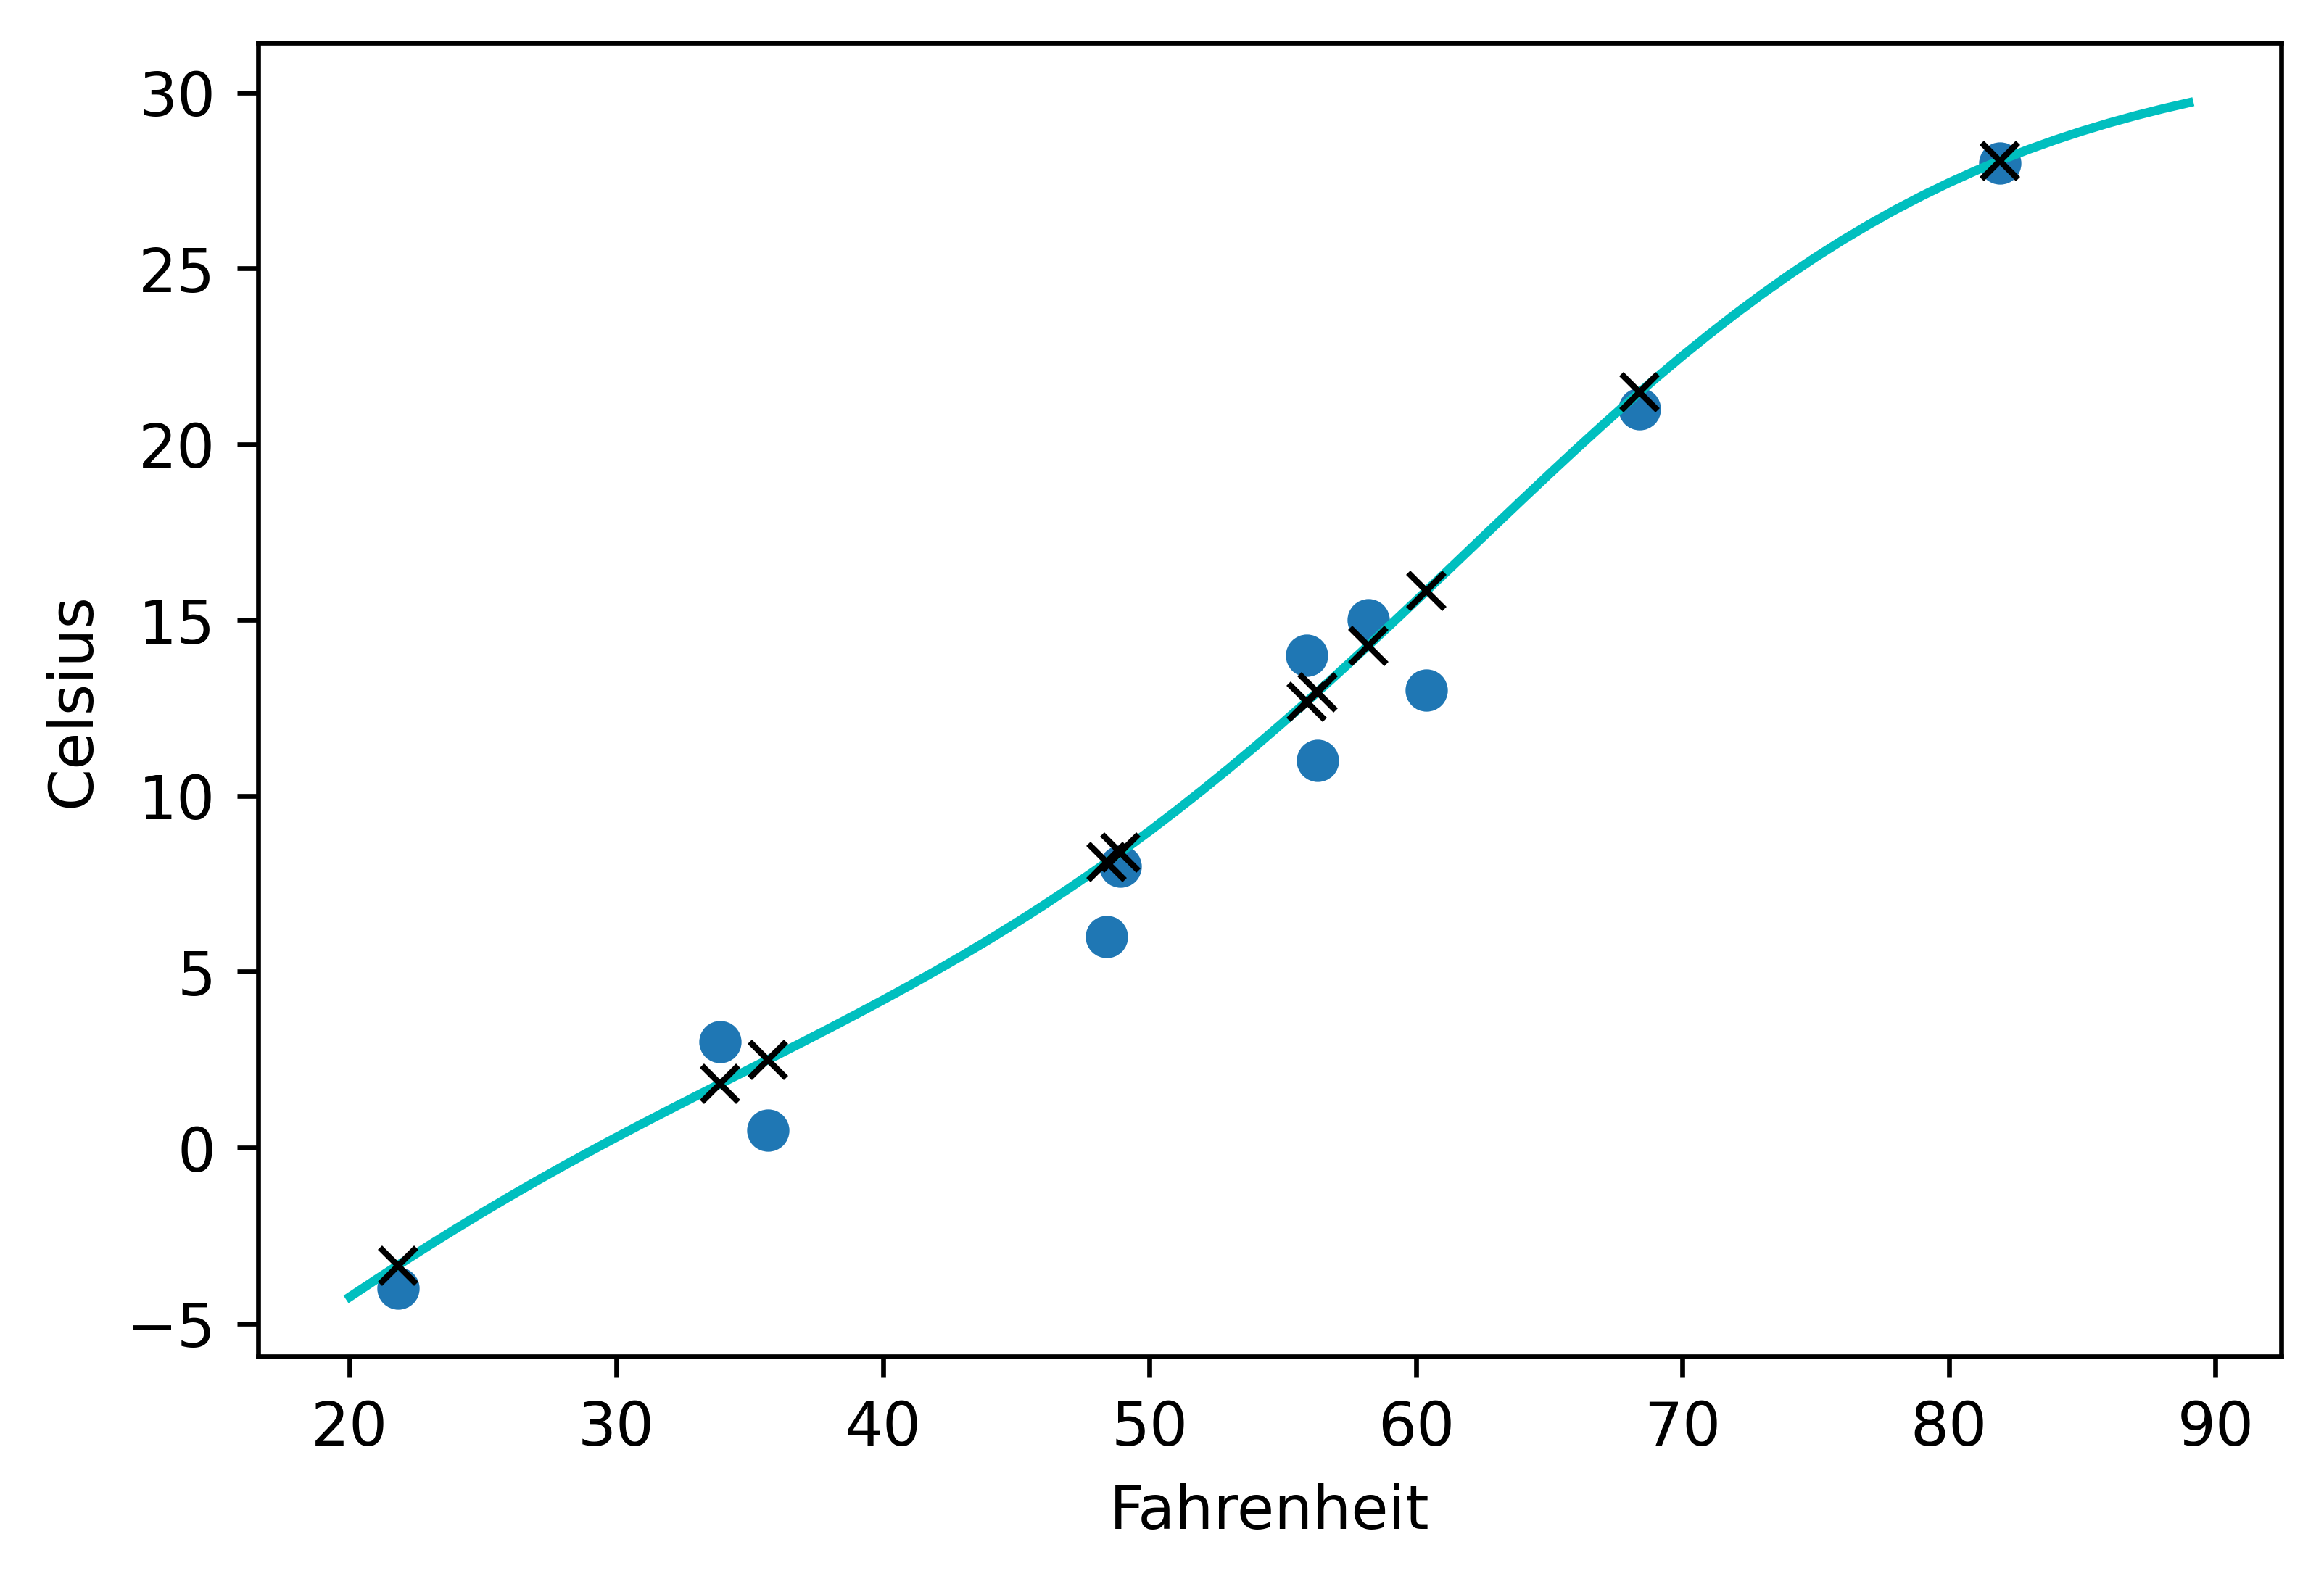

In [29]:
def plot_result(seq_model):
    t_range = torch.arange(20., 90.).unsqueeze(1)

    fig = plt.figure(dpi=600)
    plt.xlabel("Fahrenheit")
    plt.ylabel("Celsius")
    plt.plot(t_u.numpy(), t_c.numpy(), 'o')
    plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), '-c')
    plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plot_result(seq_model)

### 6.5.1 Exercise-1
- Experiment with the number of hidden neurons in our simple neural network model, as well as the learning rate.
    - What changes result in more linear output from the model?
    - Can you get the model to obviously overfit the data?
        - learning rateをあげることでoverfitが明らかになりやすい。

In [43]:
def test_neuron_number(neuron_number, learning_rate):
    seq_model = nn.Sequential(nn.Linear(1, neuron_number),
                             nn.Tanh(),
                             nn.Linear(neuron_number, 1))
    optimizer = optim.SGD(seq_model.parameters(), lr=learning_rate)

    training_loop(n_epochs=5000,
             optimizer=optimizer,
             model=seq_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_un_val,
             t_c_train=t_c_train,
             t_c_val=t_c_val)
    plot_result(seq_model=seq_model)

Epoch 1, Training loss 201.6549, Validation loss 54.0908
Epoch 1000, Training loss 3.5925, Validation loss 3.6912
Epoch 2000, Training loss 6.3373, Validation loss 0.0863
Epoch 3000, Training loss 2.7282, Validation loss 1.0052
Epoch 4000, Training loss 2.2688, Validation loss 1.3286
Epoch 5000, Training loss 2.0909, Validation loss 1.5532


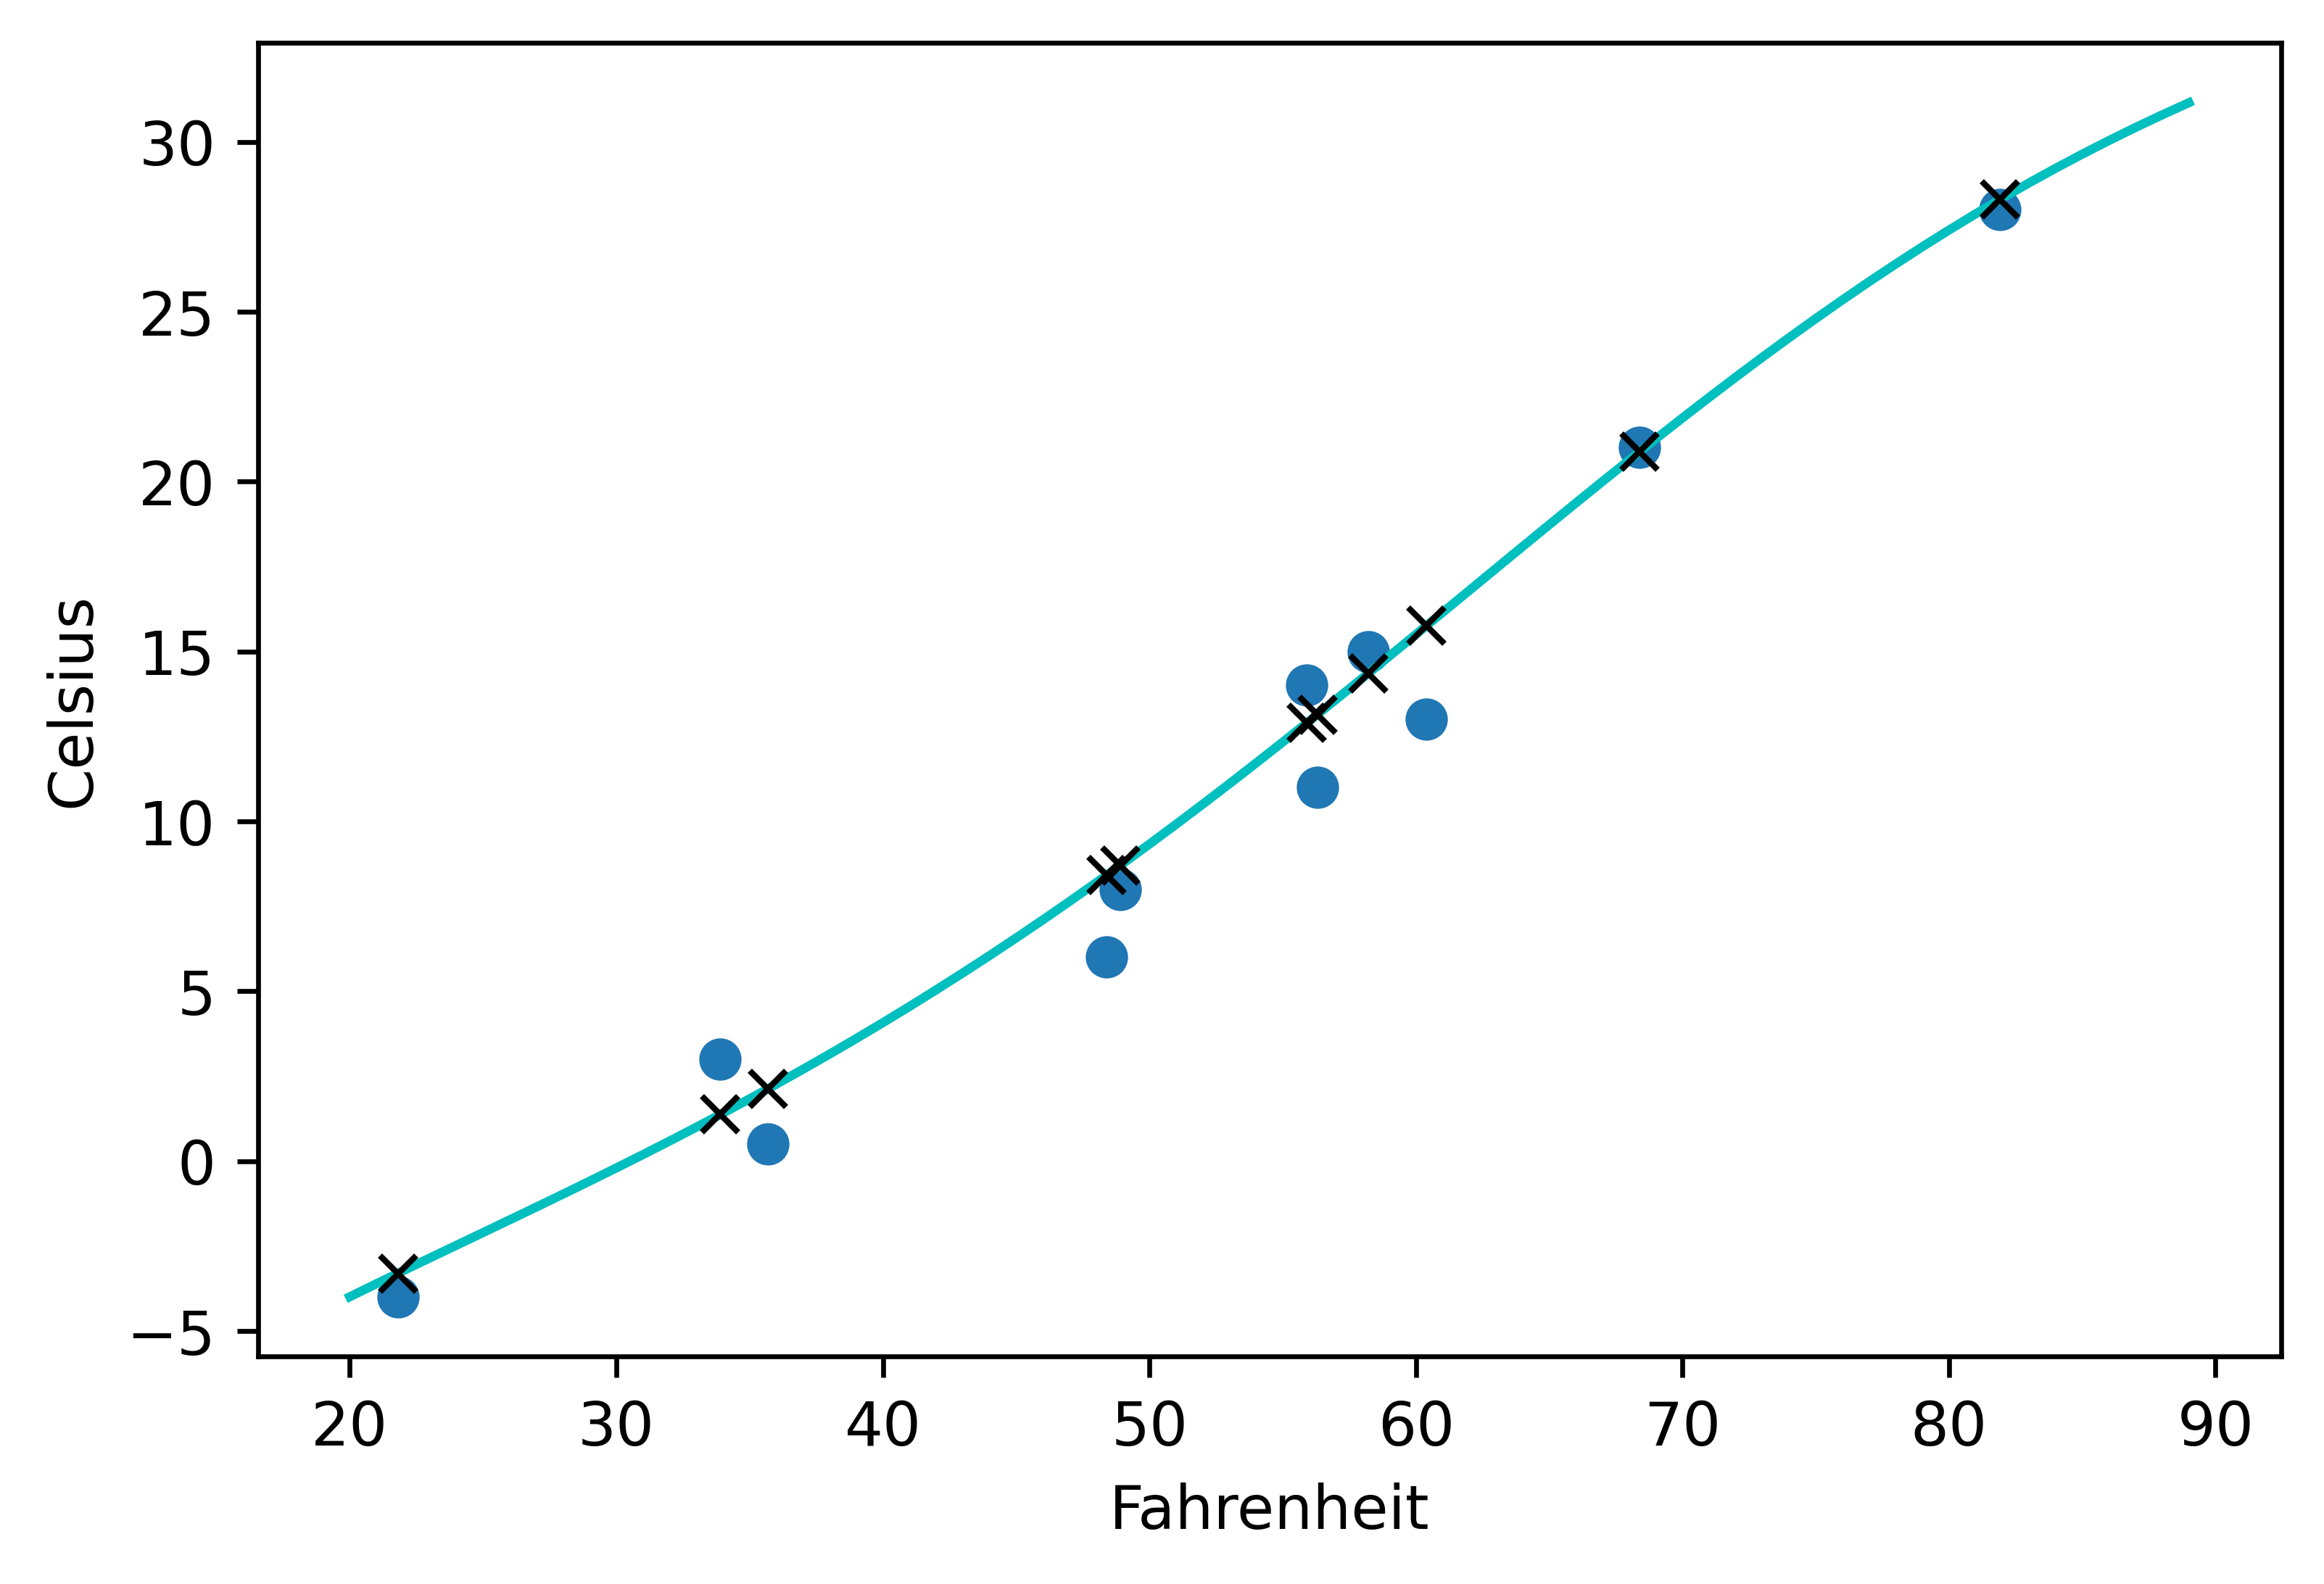

In [51]:
test_neuron_number(neuron_number=23, learning_rate=1e-3)

Epoch 1, Training loss 227.1798, Validation loss 66.4204
Epoch 1000, Training loss 13.1435, Validation loss 1.3462
Epoch 2000, Training loss 2.5637, Validation loss 2.3552
Epoch 3000, Training loss 1.6243, Validation loss 3.1418
Epoch 4000, Training loss 1.2681, Validation loss 3.8029
Epoch 5000, Training loss 1.1250, Validation loss 4.1798


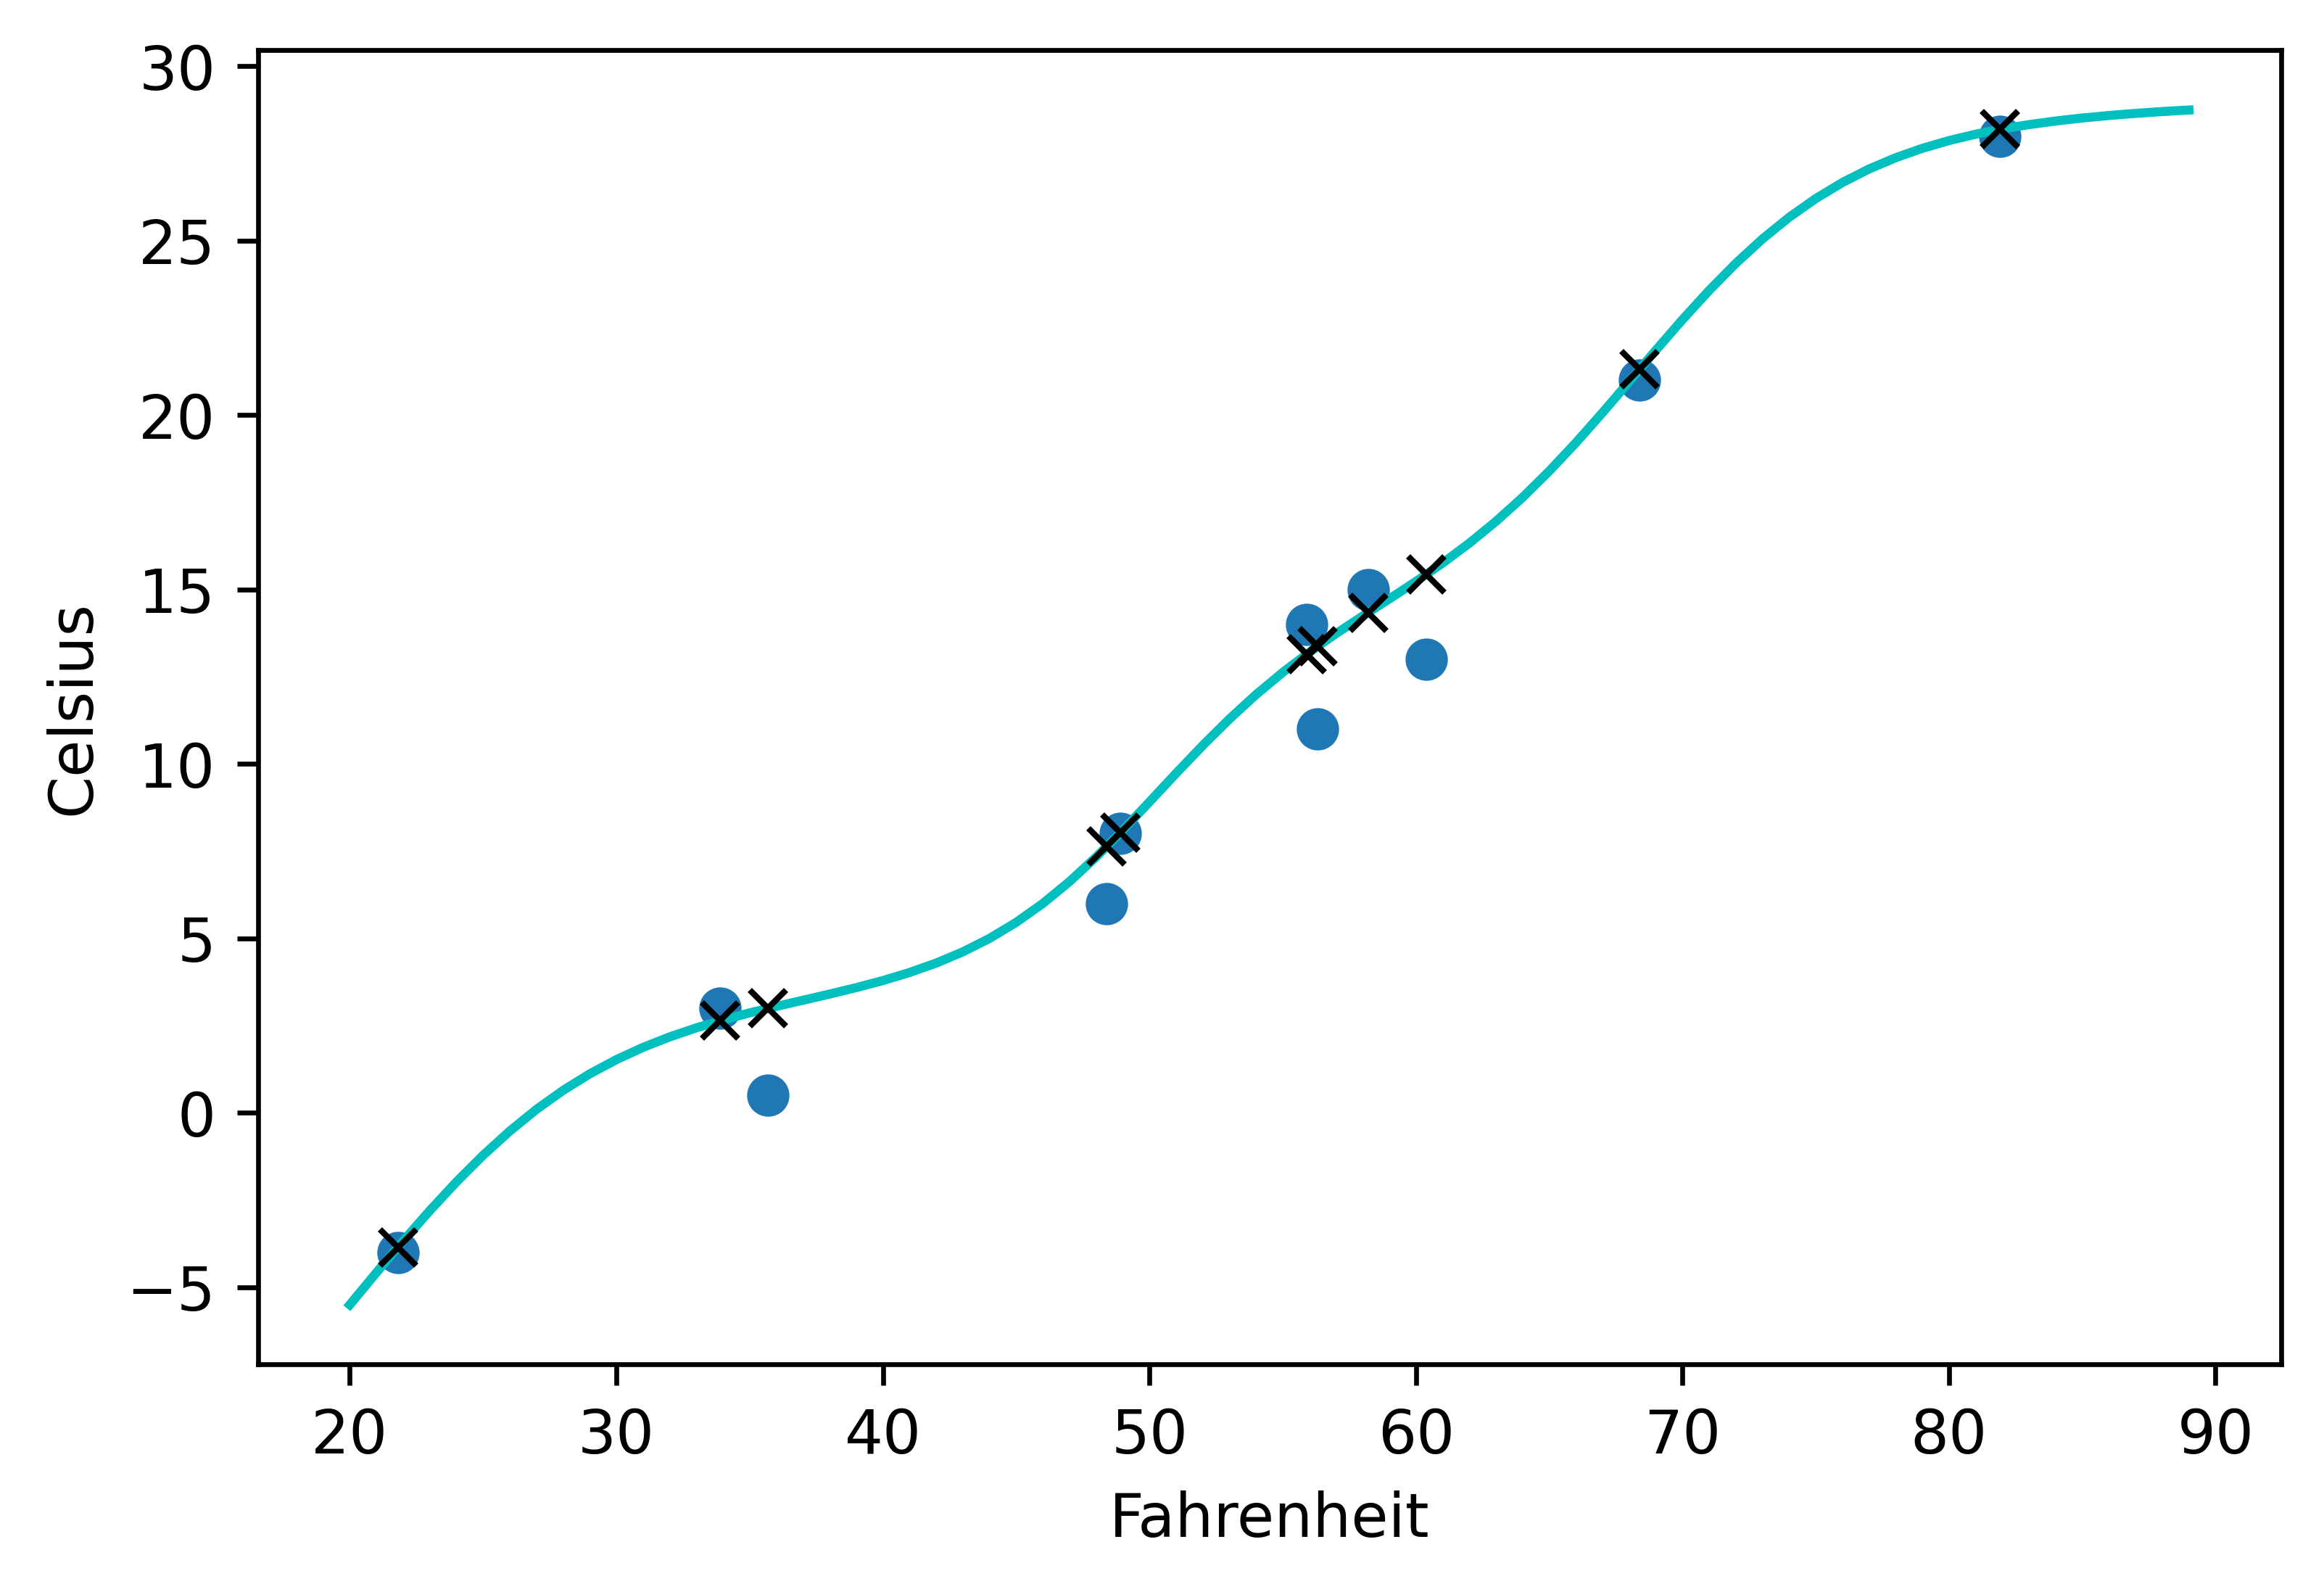

In [41]:
test_neuron_number(neuron_number=20, learning_rate=1e-2)